In [1]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
import matplotlib.pyplot as plt
from scipy import signal
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale, Lambda
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

from losses import *

Input: 
	 torch.Size([1, 3, 28, 28]) 0.0 1.0


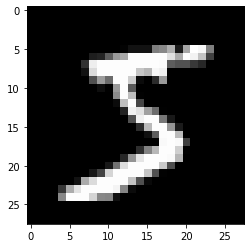

Target: 
	 torch.Size([1, 3, 28, 28]) 0.0 1.0


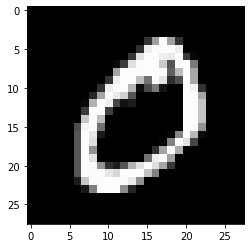

In [2]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1) ),
])
ds = MNIST("../notebooks/mnist_example/", download=False, train=True, transform=train_transform)


# train_transform = Compose([
#     Resize(28),
#     ToTensor(),
#     Grayscale(),
# ])
# ds = CIFAR10("../notebooks/cifar10_example/", download=False, train=True, transform=train_transform)

# Input example
input = ds[0][0].unsqueeze(0)
print("Input: \n\t", input.shape, input.min().item(), input.max().item())
try: # grayscale
    plt.imshow(input.squeeze(0).squeeze(0), cmap="gray")
except: # RBG
    plt.imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
plt.show()

# Target example
target = ds[1][0].unsqueeze(0)
print("Target: \n\t", target.shape, target.min().item(), target.max().item())
# plt.imshow(target.squeeze(0).squeeze(0), cmap="gray")
plt.imshow(target.squeeze(0).permute(1,2,0), cmap="gray")
plt.show()

# Dimensions
h, w = input.shape[2], input.shape[3]


Filter size:  4703


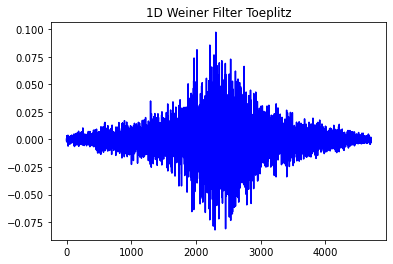

(28, 28)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


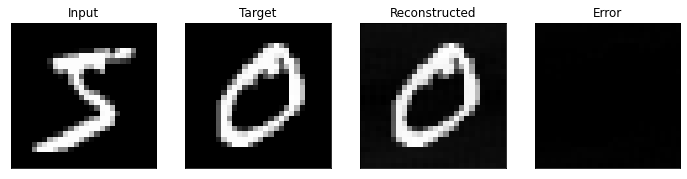

In [3]:
# 1D Weiner Filter using Toeplitz
aw1d = AWLoss1D(epsilon=0., store_filters=True)
_ = aw1d(target, input)
vfilter = aw1d.filters[0]
print("Filter size: ", len(vfilter))
plt.plot(vfilter, color="blue")
plt.title("1D Weiner Filter Toeplitz")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), vfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)

# Error
print(recon.shape)
diff = torch.from_numpy(recon) - target.squeeze(0).squeeze(0)

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
try:
    ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[0].imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
try:
    ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[1].imshow(target.squeeze(0).permute(1,2,0), cmap="gray")

ax[2].imshow(recon, cmap="gray")

try:
    ax[3].imshow(diff, cmap="gray")
except:
    ax[3].imshow(diff.permute(1,2,0).numpy(), cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

In [ ]:
# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=0., store_filters=True)
_ = aw1dfft(target, input)
wfilter = aw1dfft.filters[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner Filter FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
# recon = signal.convolve(torch.flip(input, dims=(0,1)).flatten(start_dim=0), wfilter, mode="full")
recon = signal.convolve(input.flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)

# Error
print(recon.shape)
diff = torch.from_numpy(recon) - target.squeeze(0).squeeze(0)

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
try:
    ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[0].imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
try:
    ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[1].imshow(target.squeeze(0).permute(1,2,0), cmap="gray")

ax[2].imshow(recon, cmap="gray")

try:
    ax[3].imshow(diff, cmap="gray")
except:
    ax[3].imshow(diff.permute(1,2,0).numpy(), cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

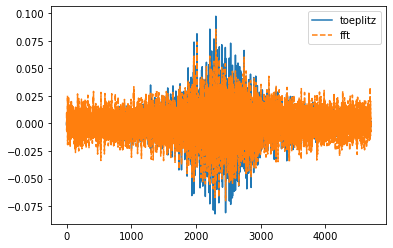

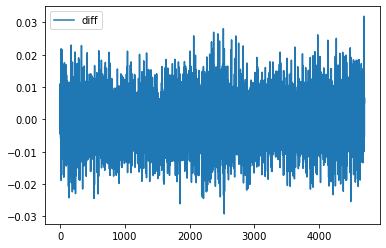

torch.Size([4703])


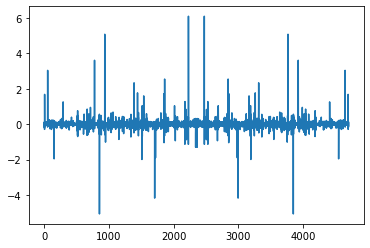

In [5]:
plt.plot(vfilter, label="toeplitz")
plt.plot(wfilter, label="fft", linestyle="--")
plt.legend()
plt.show()

diff = wfilter-vfilter
plt.plot(diff, label="diff")
plt.legend()
plt.show()

print(diff.shape)
plt.plot(torch.fft.fft(diff))
plt.show()

Filter size:  torch.Size([3, 55, 55])


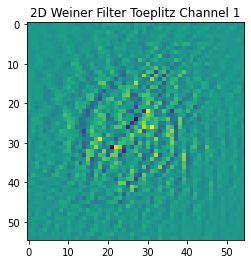

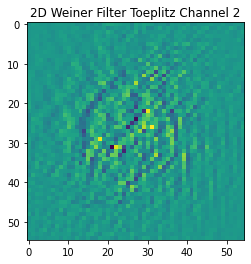

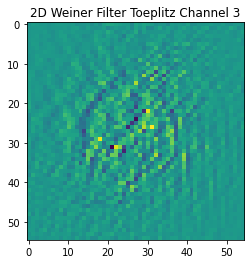

torch.Size([3, 55, 55])
(28, 28)


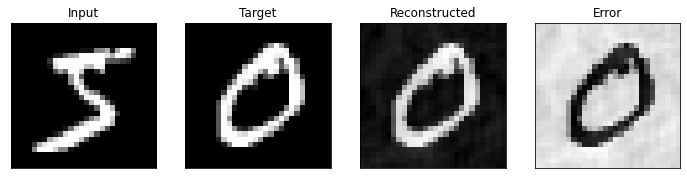

In [6]:
# 2D Weiner Filter using Toeplitz matrix
aw2d = AWLoss2D(epsilon=3e-15, store_filters=True)
_ = aw2d(target, input)
vfilter = aw2d.filters[0]
print("Filter size: ", vfilter.shape)
for i in range(vfilter.shape[0]):
    plt.imshow(vfilter[i])
    plt.title("2D Weiner Filter Toeplitz Channel %g"%(i+1))
    plt.show()


def get_middle_arr2d(img, shape):
    x_len, y_len = shape[0], shape[1]
    x_start = int(img.shape[0]/2) - int(x_len/2)
    y_start = int(img.shape[1]/2) - int(y_len/2)
    return img[x_start:x_start+x_len, y_start:y_start+y_len]

# Input convolved with filter (reconstructed target)
# recon = signal.convolve2d(torch.flip(input, dims=(0,1)).squeeze(0).squeeze(0), vfilter)
print(vfilter.shape)
try:
    recon = signal.convolve2d(input.squeeze(0).squeeze(0), vfilter[0])
except:
    recon = signal.convolve2d(input.squeeze(0).squeeze(0)[0], vfilter[0])
recon = get_middle_arr2d(recon, (h,w))

# Error
print(recon.shape)
diff = torch.from_numpy(recon) - target.squeeze(0).squeeze(0)

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
try:
    ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[0].imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
try:
    ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[1].imshow(target.squeeze(0).permute(1,2,0), cmap="gray")

ax[2].imshow(recon, cmap="gray")

try:
    ax[3].imshow(diff, cmap="gray")
except:
    ax[3].imshow(diff[0].numpy(), cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

In [6]:
# 2D Weiner Filter using Toeplitz matrix
aw2dfft = AWLoss2DFFT(epsilon=3e-15, store_filters=True)
_ = aw2dfft(target, input)
vfilter = aw2dfft.filters[0]
print("Filter size: ", vfilter.shape)
for i in range(vfilter.shape[0]):
    plt.imshow(vfilter[i])
    plt.title("2D Weiner Filter FFT Channel %g"%(i+1))
    plt.show()


# def get_middle_arr2d(img, shape):
#     x_len, y_len = shape[0], shape[1]
#     x_start = int(img.shape[0]/2) - int(x_len/2)
#     y_start = int(img.shape[1]/2) - int(y_len/2)
#     return img[x_start:x_start+x_len, y_start:y_start+y_len]

# recon = signal.convolve2d(torch.flip(input, dims=(0,1)).squeeze(0).squeeze(0), vfilter)
print(vfilter.shape)
try:
    recon = signal.convolve2d(input.squeeze(0).squeeze(0), vfilter[0])
except:
    recon = signal.convolve2d(input.squeeze(0).squeeze(0)[0], vfilter[0])
recon = get_middle_arr2d(recon, (h,w))

# Error
print(recon.shape)
diff = torch.from_numpy(recon) - target.squeeze(0).squeeze(0)

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
try:
    ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[0].imshow(input.squeeze(0).permute(1,2,0), cmap="gray")
try:
    ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
except:
    ax[1].imshow(target.squeeze(0).permute(1,2,0), cmap="gray")

ax[2].imshow(recon, cmap="gray")

try:
    ax[3].imshow(diff, cmap="gray")
except:
    ax[3].imshow(diff[0].numpy(), cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

[55, 55]
torch.Size([1, 3, 55, 55])
torch.Size([1, 3, 55, 55])


RuntimeError: When given, dim and shape arguments must have the same length

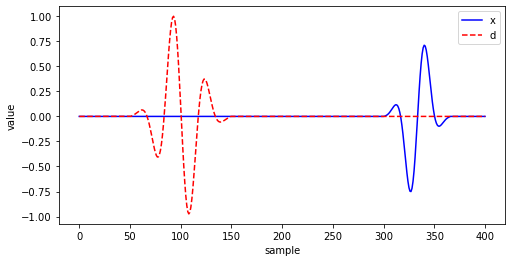

torch.Size([1, 1, 401]) torch.Size([1, 1, 401])


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import torch

def tone_burst(dt, centre_freq, n_cycles, n_samples, envelope='gaussian', offset=0, phase=lambda x:0):
    tone_length = n_cycles/centre_freq
    time_array, step = np.linspace(0, tone_length, int(tone_length/dt+1), retstep=True, endpoint=False)
    tone_burst = np.sin(2*np.pi*centre_freq*time_array+2*np.pi*centre_freq*phase(time_array))
    n_tone = tone_burst.shape[0]
    if envelope=='gaussian':
        limit = 3
        window_x = np.linspace(-limit, limit, n_tone)
        window = np.exp(-window_x**2/2)
    elif envelope=='rectangular':
        window = np.ones((tone_burst.shape[0],))
    else:
        raise Exception('Envelope type not implemented')
    tone_burst = np.multiply(tone_burst, window)
    window = get_window(('tukey', 0.05), n_tone, False)
    tone_burst = np.multiply(tone_burst, window)
    signal = np.pad(tone_burst, ((offset, n_samples-offset-n_tone),), mode='constant', constant_values=0)
    return signal

def signal_plot(x, d, xname='x', dname='d'):
    plt.figure(figsize=(8,4))
    plt.plot(x, label=xname, color='blue')
    plt.plot(d, linestyle='--', label=dname, color='red')
    plt.legend()
    plt.xlabel('sample')
    plt.ylabel('value')
    plt.show()

def complex_plot(x):
    plt.figure(figsize=(5,5))
    plt.plot(x.real, x.imag, color='blue', zorder=1)
    plt.scatter(x.real, x.imag, color='red', edgecolors='black', zorder=2)
    plt.xlabel('real')
    plt.ylabel('imaginary')
    plt.show()
    
def wiener_config(d, scale_factor=2):
    """
    Wiener filter configuration function that calculates the appropriate
    padding required for the specified size of the Wiener filter
    """
    N = len(d)              # length of vector
    P = scale_factor*N      # length of Wiener filter and number of columns in D
    M = N+P-1               # defines number of rows in D matrix
    if (M-N)%2 != 0:        
        P = P+1
        M = N+P-1
    x_pad_val = int((M-N)/2)    # amount of padding for x
    d_pad_val = int(M-N)        # amount of padding for d
    return N, P, M, x_pad_val, d_pad_val

def wienerfft(x, y, prwh=3e-5):
    """
    calculates the optimal least squares convolutional Wiener filter that 
    transforms signal x into signal y
    """
    assert len(x.squeeze()) == len(y.squeeze()), "signals x and y must be the same length"
    Fccorr = torch.fft.fft(torch.flip(x, (0,1)))*torch.fft.fft(y) # cross-correlation of x with y 
    Facorr = torch.fft.fft(torch.flip(x, (0,1)))*torch.fft.fft(x) # auto-correlation of x
    Fdconv = Fccorr/(Facorr+torch.abs(Facorr).max()*prwh) # deconvolution of Fccorr by Facorr
    return torch.fft.irfft(Fdconv, len(x.squeeze())) # inverse Fourier transform

x = np.asarray(10*tone_burst(1e-7, 3e5, 2, 401, offset=300),
                    dtype=np.float32)

d = np.asarray(10*tone_burst(1e-7, 3e5, 3, 401, offset=50),
                    dtype=np.float32)

x, d = x*0.75/np.max(np.abs(x)) , d/np.max(np.abs(d))

signal_plot(x, d)

target = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)
input = torch.from_numpy(d).unsqueeze(0).unsqueeze(0)
print(target.shape, input.shape)

Filter size:  801


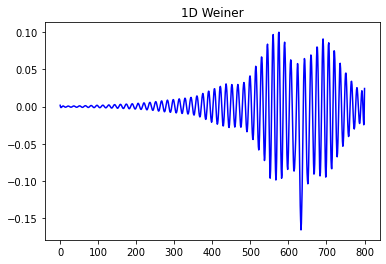

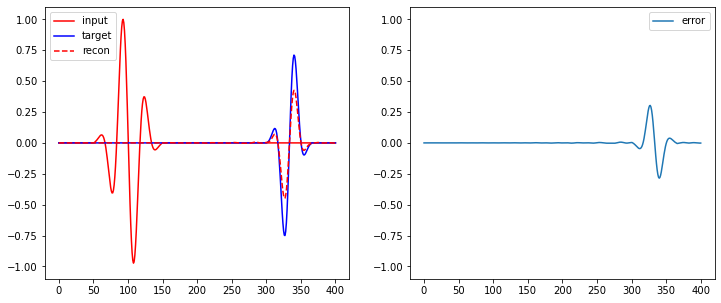

Filter size:  801


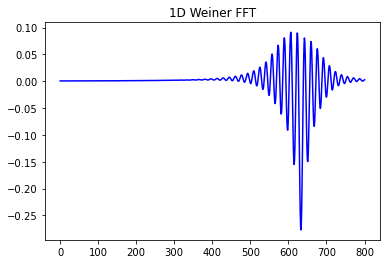

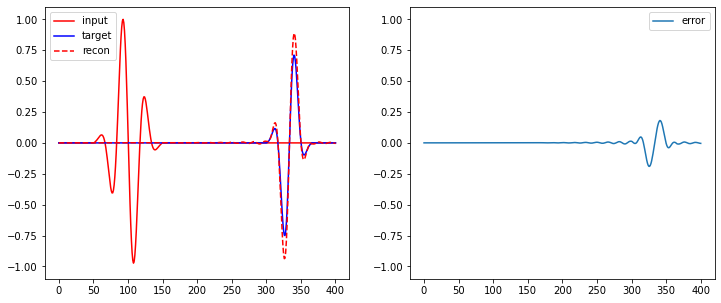

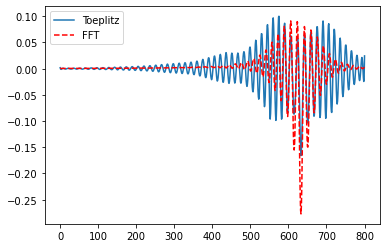

In [ ]:
# 1D Weiner Filter using Toeplits
e = 3e-5
aw1d = AWLoss1D(epsilon=e,  store_filters=True)
_ = aw1d(target, input)
vfilter = aw1d.filters[0]
print("Filter size: ", len(vfilter))
plt.plot(vfilter, color="blue")
plt.title("1D Weiner")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), vfilter, mode="full")
recon = get_middle_arr(recon, len(input.flatten()))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(input.squeeze(0).squeeze(0), label="input", color="red")
ax[0].plot(target.squeeze(0).squeeze(0), label="target", color="blue")
ax[0].plot(recon, label="recon", color="red", linestyle="--")
ax[1].plot(diff, label="error")

for i in ax:
    i.legend()
    i.set_ylim(-1.1, 1.1)
plt.show()




# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=e, store_filters=True)
_ = aw1dfft(input, target)
wfilter = aw1dfft.filters[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, len(input.flatten()))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(input.squeeze(0).squeeze(0), label="input", color="red")
ax[0].plot(target.squeeze(0).squeeze(0), label="target", color="blue")
ax[0].plot(recon, label="recon", color="red", linestyle="--")
ax[1].plot(diff, label="error")

for i in ax:
    i.legend()
    i.set_ylim(-1.1, 1.1)
plt.show()


plt.plot(vfilter, label="Toeplitz")
plt.plot(wfilter, color="red", linestyle="--", label="FFT")
plt.legend()
plt.show()

(401,) (401,)
torch.Size([1, 1203]) torch.Size([1, 1203])


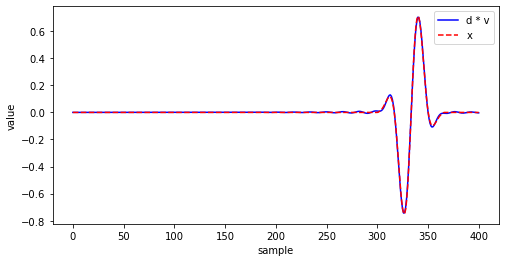

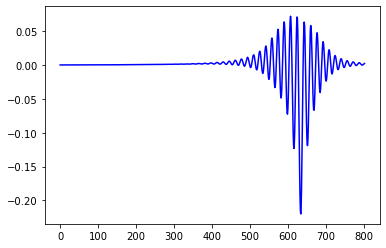

In [ ]:
N, P, M, x_pad_val, d_pad_val = wiener_config(d, 2)

x_pad = torch.from_numpy(np.pad(x, (x_pad_val, x_pad_val)))[None]

d_pad = torch.from_numpy(np.pad(d, (0,d_pad_val)))[None]


print(d.shape, x.shape)
print(d_pad.shape, x_pad.shape)
v_FD = wienerfft(d_pad, x_pad)[:,:-(M-P)]


signal_plot(np.convolve(d, v_FD.squeeze())[x_pad_val:x_pad_val+N], x, 'd * v', 'x')

plt.plot(v_FD.squeeze(), color='blue')
plt.show()

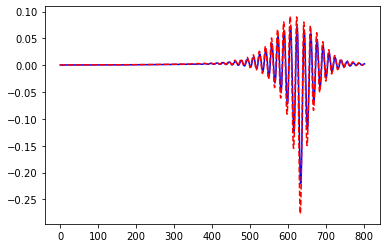

tensor(633)
tensor(634)


In [ ]:

plt.plot(v_FD.squeeze(), color='blue')
plt.plot(aw1dfft.filters[0], "--", color="red")
# plt.plot(aw1d.v_all[0], "--", color="green")
plt.show()

print(torch.argmin(aw1dfft.filters[0]))
print(torch.argmin(v_FD))


Filter size:  801


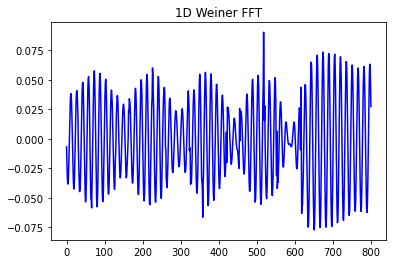

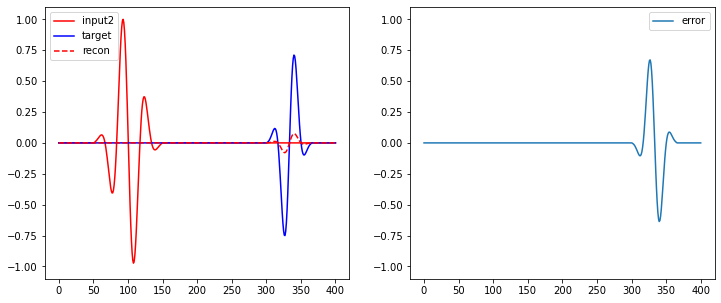

In [ ]:
# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=3e-15, store_filters=True)
input2 = input.repeat((2, 1, 1, 1))
input2[1] = -2*input2[1]
_ = aw1dfft(input2, target.repeat((2, 1, 1, 1)))
wfilter = aw1dfft.filters[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input2[0].flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, len(input2[0].flatten()))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(input2[0].squeeze(0).squeeze(0), label="input2", color="red")
ax[0].plot(target[0].squeeze(0).squeeze(0), label="target", color="blue")
ax[0].plot(recon, label="recon", color="red", linestyle="--")
ax[1].plot(diff, label="error")

for i in ax:
    i.legend()
    i.set_ylim(-1.1, 1.1)
plt.show()

In [ ]:
class AWLoss2DFFT(AWLoss):
    def __init__(self, filter_scale=2, *args, **kwargs) :
        super(AWLoss2DFFT, self).__init__(*args, **kwargs)
        self.filter_scale = filter_scale

    def wiener_config(self, input, scale_factor=2):
        """
        George Strong (geowstrong@gmail.com)
        Wiener filter configuration function that calculates the appropriate
        padding required for the specified size of the Wiener filter
        """
        N = input.shape[1]              # length of vector
        P = scale_factor*N              # length of Wiener filter and number of columns in D
        M = N+P-1                       # defines number of rows in D matrix
        if (M-N)%2 != 0:        
            P = P-1
            M = N+P-1
        
        input_pad_val = int((M-N))         # amount of padding for input
        target_pad_val = int((M-N)/2)      # amount of padding for target
        return N, P, M, input_pad_val, target_pad_val
        
    def wienerfft(self, x, y, prwh=3e-15):
        """
        George Strong (geowstrong@gmail.com)
        calculates the optimal least squares convolutional Wiener filter that 
        transforms signal x into signal y
        """

        assert x.shape == y.shape, "signals x and y must be the same size but are {} and {}".format(x.shape, y.shape)
        
        Fccorr = torch.fft.fft(torch.flip(x, (0,1))) * torch.fft.fft(y) # cross-correlation of x with y
        Facorr = torch.fft.fft(torch.flip(x, (0,1))) * torch.fft.fft(x) # auto-correlation of x
        Facorr = Facorr + torch.abs(Facorr).max()*prwh # apply pre-whitening
        Fdconv = Fccorr/(Facorr) # deconvolution of Fccorr by Facorr 
        w =  torch.fft.irfft(Fdconv, x.shape[1]) # inverse Fourier transform
        # w = torch.flip(w, dims=(0, 1))
        # print(w.shape)
        return w


    def forward(self, recon, target):
        """
        Implements AWLoss using 2D filters in the frequency domain. Each channel is treated as a separate sample
        """
        assert target.shape == recon.shape
        bs, nc = recon.size(0), recon.size(1)
        

        filter_shape = (2*recon.shape[2] - 1, 2*recon.shape[3] - 1)
        

        # Apply padding for FFT convolution
        N, P, M, recon_pad_val, target_pad_val = self.wiener_config(recon, self.filter_scale)
        recon = nn.ConstantPad1d((0, recon_pad_val), 0)(recon)
        target = nn.ConstantPad1d((target_pad_val, target_pad_val), 0)(target)

        # Reserve memory to store filters for stats and debugging
        self.filters = torch.zeros(bs, filter_shape[0], filter_shape[1]).to(recon.device) if self.store_filters else None # one filter per image 

        # Penalty function
        self.T = self.penalty2d(shape=filter_shape, stdx=self.std, stdy=self.std, device=recon.device)
        T = self.T.repeat(recon.size(0), 1)

        # Compute weiner filter
        w = self.wienerfft(recon, target, self.epsilon)[:, :-(M-P)]

        # Normalise filter and store if prompted
        w = (w.T / self.norm(w, dim=1)).T
        if self.store_filters: self.filters = w[:]

        # Compute loss
        f = 0.5 * self.norm(T - w, dim=1)
        f = f.sum()    
        if self.reduction == "mean":
            f = f / recon.size(0)


        return f



Filter size:  torch.Size([1567])


TypeError: Invalid shape (1567,) for image data

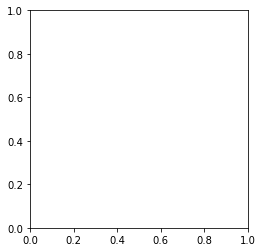

In [ ]:
# 2D Weiner Filter using Toeplitz matrix
aw2d = AWLoss2DFFT(epsilon=3e-15, store_filters=True)
_ = aw2d(target, input)
vfilter = aw2d.filters[0]
print("Filter size: ", vfilter.shape)
plt.imshow(vfilter)
plt.title("2D Weiner Filter Toeplitz")
plt.show()


def get_middle_arr2d(img, shape):
    x_len, y_len = shape[0], shape[1]
    x_start = int(img.shape[0]/2) - int(x_len/2)
    y_start = int(img.shape[1]/2) - int(y_len/2)
    return img[x_start:x_start+x_len, y_start:y_start+y_len]

# Input convolved with filter (reconstructed target)
# recon = signal.convolve2d(torch.flip(input, dims=(0,1)).squeeze(0).squeeze(0), vfilter)
recon = signal.convolve2d(input.squeeze(0).squeeze(0), vfilter)
recon = get_middle_arr2d(recon, (h,w))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()